# Suspicious Activity Detection in P2P Transactions — Case Study

**Author**: Kesley (Kes) Thao </br>
**Email**: kes.thao@gmail.com </br>
**Version**: v1.0

## Table of Contents

1. [Introduction](#1.0-Introduction)
2. [Import Packages](#2.0-Import-Packages)
3. [Data Ingestion](#3.0-Data-Ingestion)
4. [Definitions](#4.0-Definitions)
   - [Variable Definitions](#Variable-Definitions)
   - [Function Definitions](#Function-Definitions)
   - [Class Definitions](#Class-Definitions)
6. [Exploratory Data Analysis (EDA) Section](#5.0-Exploratory-Data-Analysis-(EDA)-Section)
   - [5.1 Step](#5.1-Step)
   - [5.2 Type](#5.2-Type)
   - [5.3 Amount](#5.3-Amount)
   - [5.4 nameOrig](#5.4-nameOrig)
   - [5.5 nameDest](#5.5-nameDest)
   - [5.6 isFlaggedFraud](#5.6-isFlaggedFraud)
7. [Feature Engineering](#6.0-Feature-Engineering)
   - [6.1 Step](#6.1-Step)
   - [6.2 Step](#6.2-Amount)
8. [Model](#7.0-Model)
   - [7.1 Preprocessing](#7.1-Preprocessing)
   - [7.2 Model Development](#7.2-Model-Development)
     - [Logistic Regression](#Logistic-Regression)
     - [Random Forest](#Random-Forest)
     - [XGBoost](#XGBoost)
     - [K-Nearest Neighbor](#K-Nearest-Neighbor)
8. [Model Evaluation](#8.0-Model-Evaluation)
    - [Feature Importances](#Feature-Importances)
9. [Further Explorations](#9.0-Further-Explorations)

## 1.0 Introduction

The purpose of this project is build a machine‑learning model that identifies potentially suspicious transactions with severe class imbalance and operational constraints.

Data is obtained from Kaggle's **[Synthetic Financial Datasets For Fraud Detection](#https://www.kaggle.com/datasets/ealaxi/paysim1)**.

**Metadata Definitions:**

- **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- **amount** - amount of the transaction in local currency.
- **nameOrig** - customer who started the transaction
- **oldbalanceOrg** - initial balance before the transaction
- **newbalanceOrig** - new balance after the transaction.
- **nameDest** - customer who is the recipient of the transaction
- **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 2.0 Import Packages

This section specifies the package versions used:
- python:
- pandas:
- numpy:
- scipy:
- statsmodel:
- sklearn:

In [33]:
from collections import namedtuple
from typing import List, Dict, Tuple, Union, NamedTuple, Any

from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
from pandas.plotting import scatter_matrix
import seaborn as sns
import scipy.stats

import shap
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report, 
    precision_recall_curve, roc_curve, auc, roc_auc_score,
    f1_score, precision_score, recall_score
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

## 3.0 Data Ingestion

In [2]:
file_path = 'data/PS_20174392719_1491204439457_log.csv'
df = pd.read_csv(file_path)

Look at firest 5 rows of data.

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
print(f'There are {df.shape[1]} columns/variables and {df.shape[0]:,} rows/observations in this dataset.\n')
print(df.info())

There are 11 columns/variables and 6,362,620 rows/observations in this dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [5]:
print(f'There are {df.isnull().sum().sum()} null values in this dataset.')

df.isnull().sum()

There are 0 null values in this dataset.


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.describe().style.format(precision=1, thousands=',', decimal='.')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,"6,362,620.0","6,362,620.0","6,362,620.0","6,362,620.0","6,362,620.0","6,362,620.0","6,362,620.0","6,362,620.0"
mean,243.4,"179,861.9","833,883.1","855,113.7","1,100,701.7","1,224,996.4",0.0,0.0
std,142.3,"603,858.2","2,888,242.7","2,924,048.5","3,399,180.1","3,674,128.9",0.0,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,156.0,"13,389.6",0.0,0.0,0.0,0.0,0.0,0.0
50%,239.0,"74,871.9","14,208.0",0.0,"132,705.7","214,661.4",0.0,0.0
75%,335.0,"208,721.5","107,315.2","144,258.4","943,036.7","1,111,909.2",0.0,0.0
max,743.0,"92,445,516.6","59,585,040.4","49,585,040.4","356,015,889.4","356,179,278.9",1.0,1.0


## 4.0 Definitions

### Variable Definitions

In [23]:
fraud_mask = df['isFraud'].eq(1)

In [24]:
non_fraud_mask = ~fraud_mask

### Function Definitions

In [379]:
def descriptive_stats(
    data: pd.DataFrame, col: str, 
    bool_masks: List[bool]=[non_fraud_mask, fraud_mask]) -> None:
    print(f'Variable: {col}')
    print(f'There are {data[col].nunique():,} unique {col}s.')
    print(f'There are {data[col].isna().sum()} null values.')

    if data[col].nunique() > 10:
        return None
    else:
        if is_numeric_dtype(data[col]):
            yes_series = data.loc[fraud_mask, col].describe().apply(lambda x: f'{x:,.0f}').rename('Fraud')
            no_series = data.loc[non_fraud_mask, col].describe().apply(lambda x: f'{x:,.0f}').rename('Not Fraud')
            total_series = data[col].describe().apply(lambda x: f'{x:,.0f}').rename('Total')
            df = pd.concat([yes_series, no_series, total_series], axis=1)
            df.columns = df.columns.str.title()
            print('\nSummary Statistics:\n', df)
        else:
            c = pd.crosstab(data[col], data['isFraud']).rename(columns={0: 'Not Fraud', 1: 'Fraud'})
            c['Total'] = c.sum(axis=1)
            c['Fraud Rate'] = round((c['Fraud'] / c['Total']) * 100, 2)
            c['Fraud Rate Total'] = round((c['Fraud'] / data.shape[0]) * 100, 5)
            print('\nCross Tab:')
            return c.drop(columns=['Total']) \
                .sort_values(by=['Fraud Rate Total'], ascending=False) \
                .style.format(precision=3, thousands=',', decimal='.')

In [382]:
def format_thousands(value, tick_number):
    '''Define the formatter function'''
    return f'{int(value / 1000):,}k'

def format_mil(value, tick_number):
    '''Define the formatter function'''
    return f'{int(value / 1000000):,}M'

In [87]:
def generate_violin_plot(data: pd.DataFrame, col: str) -> Axes:
    plt.figure(figsize=(6, 3), dpi=100, facecolor='w', edgecolor='k')
    for p in [0, 1]:
        plt.violinplot(data.loc[data['isFraud'].eq(p), col], positions=[p])
    plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.ylabel(col)
    plt.title(f'Violin Plot of {col} by Fraud');
    ax = plt.gca()
    return ax

In [ ]:
def generate_violin_plot(
    data: pd.DataFrame, col: str, y: str, 
    hue: str, title: str, figsize: Tuple[int]=(10, 5),
    style='white', palette Dict[int, str]={1: 'coral'}
) -> Axes:
    f, ax = plt.subplots(figsize=figsize)
    with sns.axes_style(style=style):
        sns.violinplot(data=data, x=col, y=y, hue=hue,
                       split=True, inner='quart', linewidth=1,
                       palette={**palette, **{0: '.85'}});
#         sns.despine(left=True, bottom=True)
        sns.despine(offset=10, trim=True);
        plt.title(title)
    return ax

In [48]:
def generate_count_plot(
    data: pd.DataFrame, col: str, 
    hue: str, figsize: Tuple[int]=(6, 3), 
    style: str='whitegrid', 
    x_label: Union[None, str]=None, 
    y_label: Union[None, str]=None,
    palette: Dict[int, str]={1: 'lightseagreen'},
    show_value_labels: bool=True,
    v_value_label_offset: float=1.0,
    h_value_label_offset: float=0.4,
    orient: str='v', dodge: bool=True
    ) -> Axes:
    
    with sns.axes_style(style=style):
        f, ax = plt.subplots(figsize=figsize)
        
        plotting_kwargs = dict(
            hue=hue, data=data, ax=ax, 
            palette={**{0: '.85'}, **palette},
            lw=.5, edgecolor='black', saturation=1,
            dodge=dodge, 
        )
        
        if orient == 'v':
            plotting_kwargs['x'] = col
            ax = sns.countplot(**plotting_kwargs);
        else:
            plotting_kwargs['y'] = col
            ax = sns.countplot(**plotting_kwargs);
            
        sns.despine()
        if x_label is not None:
            ax.set_xlabel(x_label)
            ax.set_ylabel('Count')
            
        if y_label is not None:
            ax.set_xlabel('Count')
            ax.set_ylabel(y_label)        
        
        plt.legend(title='Fraud Legend')
        plt.yscale('log', base=10)
        plt.title(f'Fraud Count by {col.title()}')
        plt.xlabel(f'{col.title()}')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
          
        if show_value_labels:
            show_values_on_bars(ax, orient, h_value_label_offset, v_value_label_offset)       
    return ax

def show_values_on_bars(
    ax, orient: str, h_value_label_offset: float, 
    v_value_label_offset: float
) -> None:
    # https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values    
    if orient == 'v':
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + v_value_label_offset
            value = 0 if (np.isnan(p.get_height())) else f'{int(p.get_height()) / 1000:,.2f}K'
            ax.text(_x, _y, value, ha='center', va='center') 
    elif orient == 'h':
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(h_value_label_offset)
            _y = p.get_y() + p.get_height() / 2
            value = 0 if (np.isnan(p.get_width())) else f'{int(p.get_width()) / 1000:,.2f}K'
            ax.text(_x, _y, value, ha='left', va='center')
    return None

In [383]:
def generate_percentile_plot(
        data: pd.DataFrame, col: str, 
        yticks: List[int]=None
    ) -> Axes:
    plt.figure(figsize=(10, 3), dpi=100)
    data[col].value_counts().describe(np.arange(0, 1.05, .05))[4:-1].plot()
    plt.xticks(rotation=45, minor=True)
    if yticks is not None:
        plt.yticks(ticks=yticks, minor=False)
    else:
        plt.yticks(minor=False)
    plt.xlabel('Percentile')
    plt.ylabel('Count')
    plt.title(f'Percentile Breakdown of Frequency of {col}')
    ax = plt.gca()
    return ax

In [81]:
def generate_distribution_plot(
    data: pd.DataFrame, col: str, bins: int=30, 
    bool_masks: List[bool]=[non_fraud_mask, fraud_mask],
    format_xaxis: bool=False
) -> Axes:
    non_fraud_mask, fraud_mask = bool_masks
    fig, axs = plt.subplots(1, 2, figsize=(13, 3))
    sns.histplot(
        data=data.loc[non_fraud_mask], 
        x=col, bins=bins,  ax=axs[0],
        color='.85'
    )
    axs[0].set_title(f'Distribution of {col.title()} for Non-Fraudulent Transactions')
    axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
    if format_xaxis:
        axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
    sns.histplot(
        data=data.loc[fraud_mask], x=col, bins=bins,  
        ax=axs[1], color='thistle',
        edgecolor='.3', linewidth=.5
    )
    axs[1].set_title(f'Distribution of {col.title()} for Fraudulent Transactions')
    if format_xaxis:
        axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
    return axs

In [ ]:
def generate_hist_plot(
    data: pd.DataFrame, col: str, hue: str, 
    figsize: Tuple[int]=(8, 5), style: str='white', 
    palette: str='light:m_r'
    ) -> Axes:
    f, ax = plt.subplots(figsize=figsize)
    with sns.axes_style(style=style):
        sns.histplot(data=data, x=col, hue=hue, ax=ax, multiple='stack', 
                     palette=palette, edgecolor=".3", linewidth=1);
        sns.despine()
    return ax

In [ ]:
def show_values_on_bars(ax, orient, h_value_label_offset, v_value_label_offset):
    # https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values    
    if orient == 'v':
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + v_value_label_offset
            value = 0 if (np.isnan(p.get_height())) else int(p.get_height())
            ax.text(_x, _y, value, ha='center', va='center') 
    elif orient == 'h':
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(h_value_label_offset)
            _y = p.get_y() + p.get_height() / 2
            value = 0 if (np.isnan(p.get_width())) else int(p.get_width())
            ax.text(_x, _y, value, ha='left', va='center')
            
def create_countplot(data, x, hue, figsize=(8, 4), 
                     style='whitegrid', 
                     x_label=None, y_label=None,
                     palette={'Fraud': 'lightseagreen', 'Total': 'lightsteelblue'},
                     show_value_labels=True,
                     v_value_label_offset=1,
                     h_value_label_offset=0.4,
                     legend_loc='upper right',
                     orient='v', dodge=True):
    
    with sns.axes_style(style=style):
        f, ax = plt.subplots(figsize=figsize)
        
        plotting_kwargs = dict(
            hue=hue, data=data, ax=ax, 
            palette={**{'Not Fraud': '.85'}, **palette},
            lw=.5, edgecolor='black', saturation=1,
            dodge=dodge
        )
        
        if orient == 'v':
            plotting_kwargs['x'] = x
            ax = sns.countplot(**plotting_kwargs);
        else:
            plotting_kwargs['y'] = x
            ax = sns.countplot(**plotting_kwargs);
            
        sns.despine()
        if x_label is not None:
            ax.set_xlabel(x_label)
            ax.set_ylabel('Count')
            
        if y_label is not None:
            ax.set_xlabel('Count')
            ax.set_ylabel(y_label)        
        
        plt.legend(loc=legend_loc)
          
        if show_value_labels:
            show_values_on_bars(ax, orient, h_value_label_offset, v_value_label_offset)         
    return ax

In [12]:
def create_contingency_table(data: pd.DataFrame, col: str) -> Tuple[Any]:
    cont_table = pd.crosstab(df['isFraud'], df[col]).T
    chisq, p_val, dof, expected = scipy.stats.chi2_contingency(cont_table)
    
    expected = pd.DataFrame(expected, columns=['notFraudExpected', 'fraudExpected'])
    cont_table = cont_table.reset_index()
    
    out_table = pd.concat([cont_table, expected], axis=1)
    out_table['notFraudChiSq'] = (out_table[False] - out_table['notFraudExpected']) ** 2 / out_table['notFraudExpected']
    out_table['fraudChiSq'] = (out_table[True] - out_table['fraudExpected']) ** 2 / out_table['fraudExpected']
    out_table['fraudRate'] = out_table[True] / (out_table[True] + out_table[False])
    
    print(f'Chi-Sq Statistic: {chisq:,.5f}')
    print(f'P-value: {p_val:.5f}')
    
    return (chisq, p_val, dof, out_table)

In [15]:
def plot_fraud_rate(cont_table: Union[NamedTuple, pd.DataFrame], grid: bool=True) -> None: 
    """For categorical variables, plot the fraud rate at each level.
    """
    expected_fraud_rate = cont_table['fraudExpected'] / (cont_table['fraudExpected'] + cont_table['notFraudExpected'])
    x_col = cont_table.columns[0]
    
    plt.figure(figsize=(6, 3), dpi= 100, facecolor='w', edgecolor='k')
    plt.plot(range(len(cont_table)), cont_table['fraudRate'], label='Actual Fraud Rate', color='blue')
    plt.plot(range(len(cont_table)), expected_fraud_rate, label='Expected Fraud Rate', color='red')
    plt.legend()
    plt.xticks(range(len(cont_table)), cont_table[x_col], rotation=90)
    ypos, ylabs = plt.yticks()
    plt.yticks(ypos, ['{:.2%}'.format(y) for y in ypos])
    plt.ylabel('Fraud Rate')
    plt.xlabel(x_col.title())
    plt.title(f'Plot of Fraud Rate by {x_col.title()}')
    if grid:
        plt.grid()
    return None

In [6]:
def ttest(data: pd.DataFrame, col: str) -> Tuple[Any]:
    """
    Perform a 2 sample t-test (assuming unequal variances) of the col_name values between the fraud and not fraud groups.
    """
    fraud = data.loc[data['isFraud'].eq(1), col]
    not_fraud = data.loc[data['isFraud'].eq(0), col]
    
    comparison = pd.DataFrame(df.groupby('isFraud')[col].describe())
    t, p_val = scipy.stats.ttest_ind(fraud, not_fraud, equal_var=False)
    
    print(f'T-statistic: {t:,.5f}')
    print(f'P-value: {p_val:,.5f}')
    
    return (t, p_val, comparison)

In [29]:
def generate_eval_plots(cm, fpr, tpr, roc_auc, cmap='Blues', class_labels=None):
    fig, axs = plt.subplots(1, 2, figsize=(13, 3))
    
    axs[0].set_title('ROC Curve')
    axs[0].plot(fpr, tpr, color='darkorange',
                lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()

    df_cm = pd.DataFrame(cm.T, index=class_labels, columns=class_labels)
    axs[1].set_title('Confusion Matrix')
    sns.heatmap(df_cm, square=True, annot=True, fmt='d', cbar=True, 
        cmap=cmap, annot_kws={"size": 10}, ax=axs[1], linecolor='black', linewidths=.5)
    axs[1].set_xlabel('True Labels')
    axs[1].set_ylabel('Predicted Labels')

def plot_roc_auc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
           
def plot_confusion_matrix(cm, cmap='Blues', class_labels=None):
    df_cm = pd.DataFrame(cm.T, index=class_labels, columns=class_labels)
    sns.heatmap(df_cm, square=True, annot=True, fmt='d', cbar=True, 
        cmap=cmap, annot_kws={"size": 12}, linecolor='black')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.show()

In [16]:
def create_train_test_val_data(X, y, random_state):
    # https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
    train_ratio = 0.75
    val_ratio = 0.15
    test_ratio = 0.10
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 - train_ratio, random_state=random_state
    )
    
    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=test_ratio/(test_ratio + val_ratio), random_state=random_state)
    return (X_train, X_test, X_val, y_train, y_test, y_val)

### Classs Definitions

In [35]:
class Model:
    def __init__(self, X_train, X_test, y_train, y_test, classifier='log_reg', **kwargs):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.classifier = classifier
        self.kwargs = kwargs

        self.classifier_dict = dict(
            log_reg=LogisticRegression,
            rfc=RandomForestClassifier,
            gboost=GradientBoostingClassifier,
            xgboost=XGBClassifier,
            knn=KNeighborsClassifier,
            nb=GaussianNB,
            svm=SVC
        )
        self.model = None
        self.model_name = None
        self.fpr = None
        self.tpr = None
        
    def fit(self):
        if self.classifier in ('rfc', 'gboost'):
            model = self.classifier_dict.get(self.classifier, LogisticRegression)(
                n_estimators=self.kwargs.get('n_estimators'),
                max_depth=self.kwargs.get('max_depth'), 
                max_features=self.kwargs.get('max_features')
            ).fit(self.X_train, self.y_train)
            
        if self.classifier == 'tree':
            model = self.classifier_dict.get(self.classifier, LogisticRegression)(
                max_depth=self.kwargs.get('max_depth'), 
                max_features=self.kwargs.get('max_features')
            ).fit(self.X_train, self.y_train)
            
        if self.classifier == 'xgboost':
            self.model = self.classifier_dict.get(self.classifier, LogisticRegression)(
                n_estimators=self.kwargs.get('n_estimators'),
                max_depth=self.kwargs.get('max_depth'), 
                min_child_weight=self.kwargs.get('min_child_weight'),
            ).fit(self.X_train, self.y_train)

        if self.classifier == 'svm':
            self.model = self.classifier_dict.get(self.classifier, LogisticRegression)(
                kernel='linear', probability=True
            ).fit(self.X_train, self.y_train)
            
        self.model = self.classifier_dict.get(self.classifier, LogisticRegression)().fit(self.X_train, self.y_train)
        self.model_name = self.model.__class__.__name__
        return self

    def predict(self):
        self.y_pred = self.model.predict(self.X_train)
        self.train_accuracy = f'{round(accuracy_score(self.y_train, self.y_pred) * 100, 2)}%'
    
        self.y_pred_test = self.model.predict(self.X_test)
        self.test_accuracy = f'{round(accuracy_score(self.y_test, self.y_pred_test) * 100, 2)}%'
        return self

    def evaluate(self, cmap='Blues'):
        self.cm = confusion_matrix(self.y_test, self.y_pred_test)
        tp = self.cm[1, 1]
        tn = self.cm[0, 0]
        fn = self.cm[1, 0]
        fp = self.cm[0, 1]
                             
        self.conf_mat_df = pd.DataFrame(confusion_matrix(self.y_test, self.y_pred_test))
        self.conf_mat_df.columns = ['predNotFraud', 'predFraud']
        self.conf_mat_df.index = ['actualNotFraud', 'actualFraud']
        
        self.metrics_df = pd.DataFrame({
            'Classifier': [self.model_name],
            'Accuracy': [accuracy_score(self.y_test, self.y_pred_test)],
            'AUC': [roc_auc_score(self.y_test, self.y_pred_test)],
            'F1': [f1_score(self.y_test, self.y_pred_test)],
            'Precision': [precision_score(self.y_test, self.y_pred_test)],
            'Recall': [recall_score(self.y_test, self.y_pred_test)],
            'TPR': [tp / (tp + fn)],
            'TNR': [tn / (tn + fp)],
            'FPR': [fp / (fp + tn)],
            'FNR': [fn / (fn + tp)]
        })
        
        print(f'{self.model_name}:')
        print('Train Accuracy:', self.train_accuracy)
        print('Test Accuracy:', self.test_accuracy)
        print(classification_report(self.y_test, self.y_pred_test))

        if self.classifier == 'svm':
            self.y_predict_prob = self.model._predict_proba_lr(self.X_test, self.y_test)
        else:
            self.y_predict_prob = self.model.predict_proba(self.X_test)[: ,1]
    
        self.fpr, self.tpr, _ = roc_curve(self.y_test, self.y_predict_prob)
        self.roc_auc = auc(self.fpr, self.tpr)

        generate_eval_plots(self.cm, self.fpr, self.tpr, self.roc_auc, cmap=cmap, class_labels=['Non-Fraud', 'Fraud'])
        return self

## 5.0 Exploratory Data Analysis (EDA) Section

#### Correlation Between Variables and Target Label

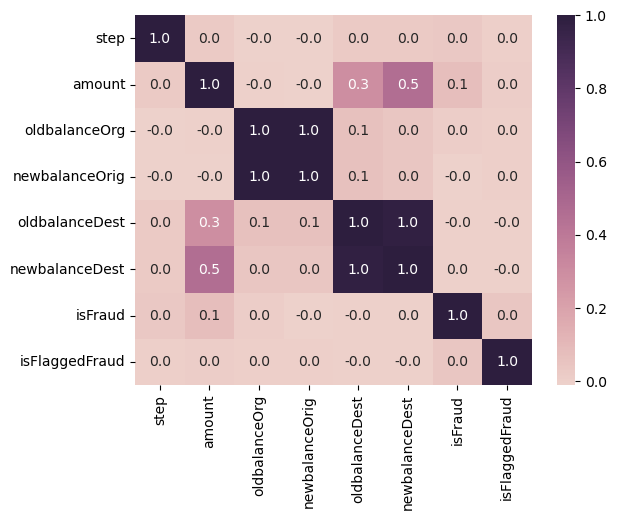

In [15]:
sns.heatmap(
    df.drop(columns=['type', 'nameOrig', 'nameDest']).corr(), 
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot=True, fmt='.1f'
);

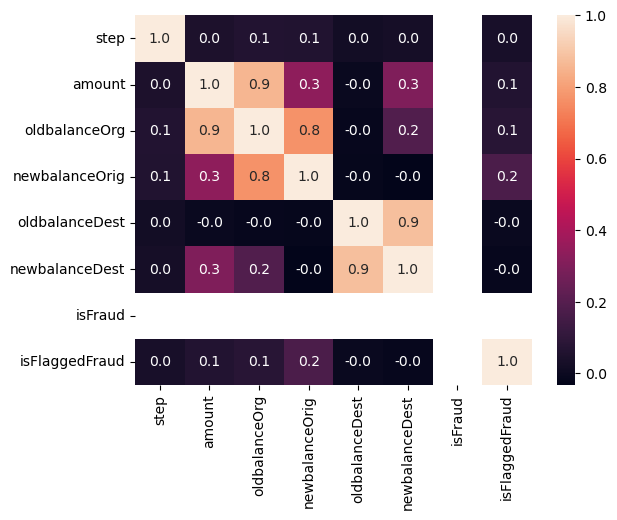

In [16]:
fraud = df.drop(columns=['type', 'nameOrig', 'nameDest']).loc[fraud_mask]
sns.heatmap(
    fraud.corr(), 
    annot=True, fmt='.1f'
);

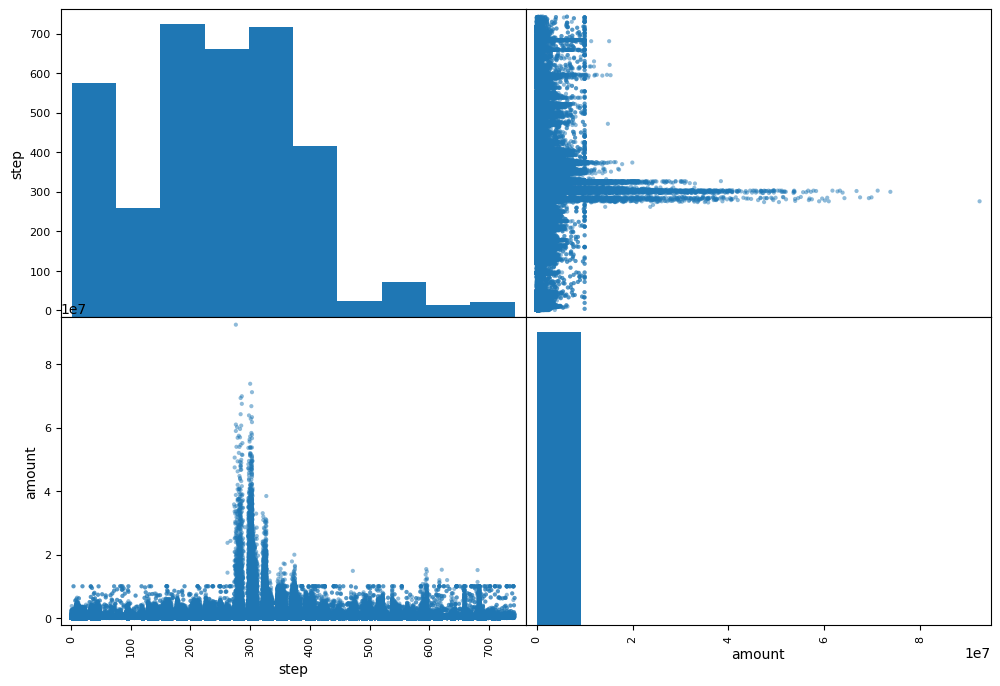

In [30]:
attributes = ['step', 'amount']
scatter_matrix(df[attributes], figsize=(12, 8));

#### 5.1 Step

From the data description, `step` maps a unit of time in the real world which is equivalent to 1 hour of time.  There are a total of 744 steps for a 30 days simulation.

The distribution plot for step by transaction count appears to be right skewed with most of the transactions concentrated at > 100 and < 400 steps.  When fraud and non-fraud transactions are separated and their distributions plotted, there's an apparent difference between the two.  The distribution for fraud appears to be relatively uniform across all steps.  However, the distribution for the non-fraud transactions mirror the overall population distribution.

In [15]:
descriptive_stats(data=df, col='step')

Variable: step
There are 743 unique steps.
There are 0 null values.

Summary Statistics:
        Fraud  Not Fraud      Total
count  8,213  6,354,407  6,362,620
mean     368        243        243
std      216        142        142
min        1          1          1
25%      181        156        156
50%      367        239        239
75%      558        334        335
max      743        718        743




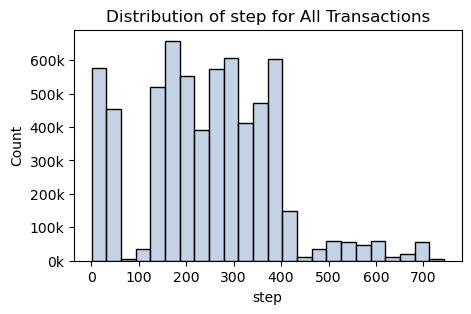

In [22]:
plt.figure(figsize=(5, 3))
ax = sns.histplot(
        data=df, 
        x='step', bins=24, 
        color='lightsteelblue'
)
ax.set_title(f'Distribution of step for All Transactions')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands));

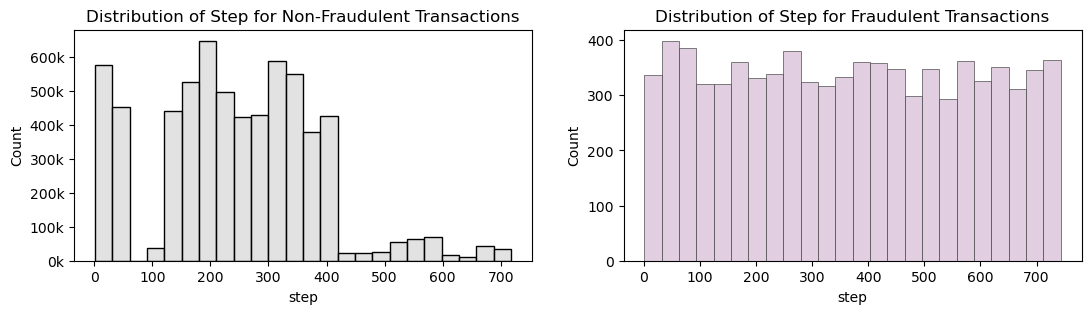

In [21]:
generate_distribution_plot(data=df, col='step', bins=24);

#### 5.2 Type

**Type** is the transaction type and there are five types in total: `CASH_OUT`, `TRANSFER`, `CASH_IN`, `DEBIT`, and `PAYMENT`.

In the below cross tabulation for fraud and non-fraud transactions, fraud appears to occur in only two of the five transaction types, namely **TRANSFER** and **CASH_OUT**.  Additionally, the number of `CASH_OUT` is similiar to `TRANSFER`, so there might be a pattern of bad actors transferring money to a potential fraudster who then cashes out the money at a merchant.  However, the data doesn't really support this as there are no frauds committed for receivers/payees who are Merchants (`nameDest` starts with 'M') and we're only seeing `PAYMENT` transaction types associated with Merchant receivers.

In [40]:
descriptive_stats(data=df, col='type')

Variable: type
There are 5 unique types.
There are 0 null values.

Cross Tab:


isFraud,Not Fraud,Fraud,Fraud Rate,Fraud Rate Total
type,,,,
CASH_OUT,"2,233,384","4,116",0.180,0.065
TRANSFER,"528,812","4,097",0.770,0.064
CASH_IN,"1,399,284",0,0.000,0.000
DEBIT,"41,432",0,0.000,0.000
PAYMENT,"2,151,495",0,0.000,0.000


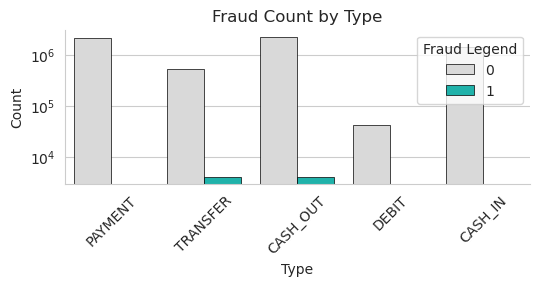

In [49]:
generate_count_plot(
    data=df, col='type', hue='isFraud', 
    palette={1: 'lightseagreen'},
    x_label='Transaction Type', show_value_labels=False,
    orient='v', v_value_label_offset=20,
    figsize=(6, 2)
);

**Find `CASH_OUT`s to Merchants (nameDest starts with 'M') where fraud has been committed.**

In [46]:
fraud_types = df.loc[
    fraud_mask & df['type'].isin(['CASH_OUT', 'TRANSFER']), ['type', 'nameOrig', 'nameDest']
    ]
fraud_types['isMerchant'] = np.where(
    fraud_types['type'].eq('CASH_OUT') &
    fraud_types['nameDest'].str.startswith('M'), 
    1, 0
)
print(fraud_types.loc[fraud_types['isMerchant'].eq(1)])

Empty DataFrame
Columns: [type, nameOrig, nameDest, isMerchant]
Index: []


**Breakdow of Fraud and Non-Fraud Transactions for Merchants by Transaction Type.**

In [50]:
df.loc[
    df['nameDest'].str.startswith('M'), ['type', 'nameDest', 'isFraud']
    ].groupby(['isFraud', 'type']).size()

isFraud  type   
0        PAYMENT    2151495
dtype: int64

**Is there a significant difference in fraud rate by transaction types?**

A Chi-Square test was performed to determine if fraud rates deviate from expected for the different transaction types.  Since the p-value we get is $\lt$ $\alpha$-level = 0.05, there's evidence to support a significant difference fraud rate by transaction type.

In [59]:
type_cont_table = create_contingency_table(df, 'type')
type_cont_table[-1].style.format(precision=5, thousands=',', decimal='.')

Chi-Sq Statistic: 22,082.53571
P-value: 0.00000


,type,0,1,notFraudExpected,fraudExpected,notFraudChiSq,fraudChiSq,fraudRate
0,CASH_IN,"1,399,284",0,"1,397,477.77560","1,806.22440",2.33452,"1,806.22440",0.00000
1,CASH_OUT,"2,233,384","4,116","2,234,611.78925","2,888.21075",0.67460,521.93782,0.00184
2,DEBIT,"41,432",0,"41,378.51873",53.48127,0.06912,53.48127,0.00000
3,PAYMENT,"2,151,495",0,"2,148,717.80626","2,777.19374",3.58949,"2,777.19374",0.00000
4,TRANSFER,"528,812","4,097","532,221.11017",687.88983,21.83685,"16,895.19389",0.00769


The following plot of expected fraud rate by type also shows significantly higher rate for `TRANSFERS`.

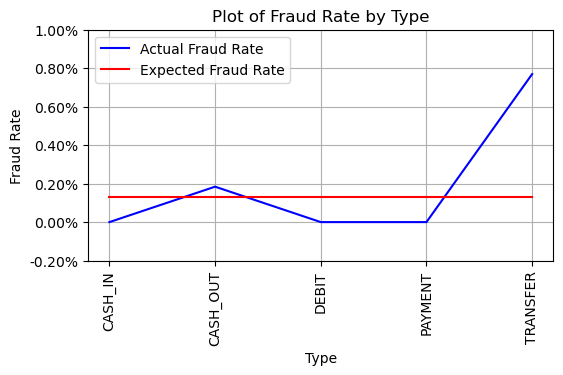

In [71]:
plot_fraud_rate(type_cont_table[-1])

#### 5.3 Amount

The average transaction amount for fraud transactions is `$1.268M` with a standard deviation of `$2.4M` while the average non-fraud transaction amount is `$178K` with a standard deviation of `$600K` indicating that fraudulent transactions tend to be higher.

The distributions of the fraud vs non-fraud population also supports this, as 95% of non-frauds are below `$515K` while only `55%` of fraud transactions are under `$550K`.


In [77]:
descriptive_stats(data=df, col='amount')

Variable: amount
There are 5,316,900 unique amounts.
There are 0 null values.

Summary Statistics:
             Fraud   Not Fraud       Total
count       8,213   6,354,407   6,362,620
mean    1,467,967     178,197     179,862
std     2,404,253     596,237     603,858
min             0           0           0
25%       127,091      13,368      13,390
50%       441,423      74,685      74,872
75%     1,517,771     208,365     208,721
max    10,000,000  92,445,517  92,445,517


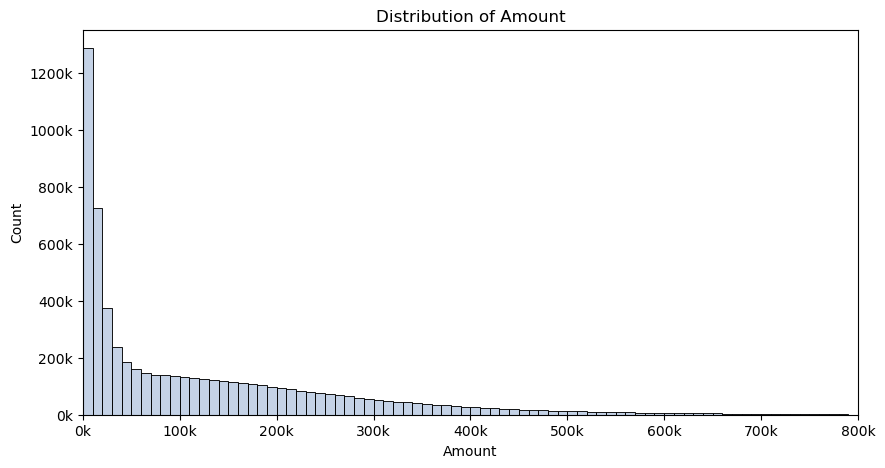

In [78]:
plt.figure(figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
sns.histplot(data=df, x='amount', bins=range(0, 800000, 10000), color='lightsteelblue')
plt.xlim(0, 800000)
plt.title('Distribution of Amount')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands));

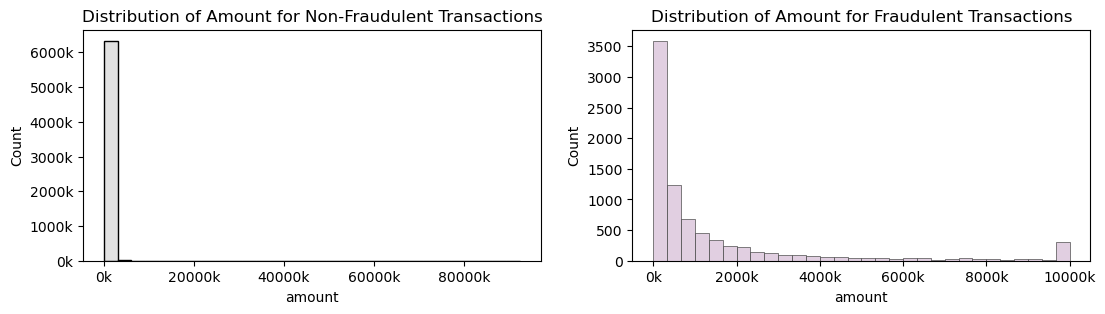

In [82]:
generate_distribution_plot(data=df, col='amount', format_xaxis=True);

**Is there a significant different in average transaction amount for fraud and non-fraud populations?**

A 2-sample t-test was performed comparing the average transaction amount for fraud vs not fraud. Since the p-value $\lt$ $\alpha$-level = 0.05, there is evidence of a difference in average transaction amount between fraud and non-fraudulent transactions. In general, fraudulent purchases had higher transaction amounts, with an average of `$1.5M` dollars vs non-fraudulent with and average of `$180K`.

In [91]:
ttest(df, 'amount')[-1].style.format(precision=2, thousands=',', decimal='.')

T-statistic: 48.61450
P-value: 0.00000


,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,"6,354,407.00","178,197.04","596,236.98",0.01,"13,368.40","74,684.72","208,364.76","92,445,516.64"
1,"8,213.00","1,467,967.30","2,404,252.95",0.00,"127,091.33","441,423.44","1,517,771.48","10,000,000.00"


#### 5.4 nameOrig

There are `6,353,307` unique senders/payors across `6,362,620` transactions.  The most transactions made by a single payor/sender is `3` with `95%` of senders making only one transaction within the one-month period.

Of the `8,213` fraud transactions, `28` were made by senders who had 2 transactions for the month while 8,185 were by senders who had 1 transaction and that transaction was a fraudulent one.  Right now, `nameOrig` does not appear to be very useful for identifying fraudulent activity as one would assume frequency is positively correlated with fraud rate.

In [12]:
descriptive_stats(data=df, col='nameOrig')

Variable: nameOrig
There are 6,353,307 unique nameOrigs.
There are 0 null values.


In [6]:
df['nameOrig_count'] = df.groupby('nameOrig')['nameOrig'].transform('count')
df['nameOrigDest_count'] = df.groupby(['nameOrig', 'nameDest'])[['nameOrig']].transform('count')

In [57]:
print('The max number of transactions made by a single payor/sender:', df['nameOrig_count'].max())
print('The max number of transactions made by a single payor/sender where fraud occurred:', df.loc[fraud_mask, 'nameOrig_count'].max())
print('The max number of transactions made by the same sender to the same reciever:', df['nameOrigDest_count'].max())

The max number of transactions made by a single payor/sender: 3
The max number of transactions made by a single payor/sender where fraud occurred: 2
The max number of transactions made by the same sender to the same reciever: 1


In [43]:
print(f'There are {len(df.loc[df["nameOrig_count"] == 3, "nameOrig"].drop_duplicates()):,.0f} sendors with 3 transactions.')
print(f'There are {len(df.loc[df["nameOrig_count"] == 2, "nameOrig"].drop_duplicates()):,.0f} sendors with 2 transactions.')
print(f'There are {len(df.loc[df["nameOrig_count"] == 1, "nameOrig"].drop_duplicates()):,.0f} sendors with 1 transactions.')

There are 15 sendors with 3 transactions.
There are 9,283 sendors with 2 transactions.
There are 6,344,009 sendors with 1 transactions.


In [44]:
df['nameOrig'].value_counts().describe(np.arange(0, 1.05, .05))[4:-1].apply(lambda x: f'{x:,.3f}')

0%      1.000
5%      1.000
10%     1.000
15%     1.000
20%     1.000
25%     1.000
30%     1.000
35%     1.000
40%     1.000
45%     1.000
50%     1.000
55%     1.000
60%     1.000
65%     1.000
70%     1.000
75%     1.000
80%     1.000
85%     1.000
90%     1.000
95%     1.000
100%    3.000
Name: count, dtype: object

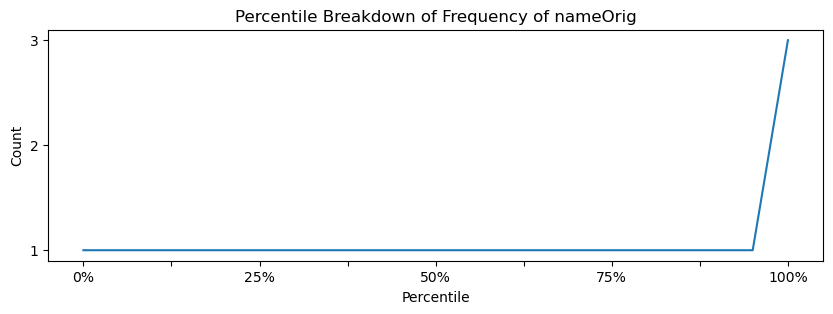

In [47]:
generate_percentile_plot(data=df, col='nameOrig', yticks=[1, 2, 3]);

**Are there any sender that made multple transactions where only 1 transaction was identified as fraud?**

There are `28` senders who had more than 1 transactions where only 1 of the transactions was identified as fraud.

In [51]:
senders_fraud_list = df.loc[fraud_mask, 'nameOrig'].drop_duplicates().to_list()
print(f'{len(senders_fraud_list):,}')

8,213


In [49]:
sender_df = df.loc[
    (df['nameOrig_count'] > 1) & df['nameOrig'].isin(senders_fraud_list), 
    ['nameOrig', 'step', 'type', 'nameDest', 'isFraud']
    ].sort_values(by=['nameOrig', 'step'], ascending=[True, True])

In [50]:
print(len(sender_df['nameOrig'].drop_duplicates()))

28


**Are there any senders who had multiple transactions with the same receiver/merchant where only one of the transactions was identified as fraud?**

No, there aren't any.

In [52]:
sender_receiver_df = df.loc[
    (df['nameOrigDest_count'] > 1) & df['nameOrig'].isin(senders_fraud_list), 
    ['nameOrig', 'step', 'type', 'nameDest', 'isFraud']
    ].sort_values(by=['nameOrig', 'step'], ascending=[True, True])

In [53]:
print(len(sender_receiver_df['nameOrig'].drop_duplicates()))

0


**Is there an association between senders who made frequent transactions and fraud rate?**

Of the 8,213 fraud transactions, only 28 were made by senders who had 2 transactions for the month while 8,185 were by senders who had only 1 transaction and that transaction was a fraudulent one.

In [56]:
fraud_senders_cnt = df.loc[fraud_mask, ['nameOrig','nameOrig_count']].drop_duplicates().reset_index(drop=True)
fraud_senders_cnt.drop(columns=['nameOrig']).value_counts()

nameOrig_count
1                 8185
2                   28
Name: count, dtype: int64

In [58]:
fraud_senders_cnt.drop(columns=['nameOrig']).value_counts().sum()

np.int64(8213)

#### 5.5 nameDest

There are `2,722,362` unique receivers/merchants across `6,362,620` transactions.  The most transactions received by a single receiver/merchant is `113` with `95%` making `10 or fewer` transactions within the one-month period.

There are `28` senders who had more than 1 transactions where only 1 of the transactions was identified as fraud.

There aren't any senders with multiple transactions with the same receiver/merchant where only one of the transactions was identified as fraud.

In [380]:
descriptive_stats(data=df, col='nameDest')

Variable: nameDest
There are 2,722,362 unique nameDests.
There are 0 null values.


In [7]:
df['nameDest_count'] = df.groupby('nameDest')['nameDest'].transform('count')

In [381]:
print('The max number of transactions received by a single receiver/merchant:', df['nameDest_count'].max())
print('The max number of transactions made by the same sender to the same reciever:', df['nameOrigDest_count'].max())

The max number of transactions received by a single receiver/merchant: 113
The max number of transactions made by the same sender to the same reciever: 1


<Axes: title={'center': 'Percentile Breakdown of Frequency of nameDest'}, xlabel='Percentile', ylabel='Count'>

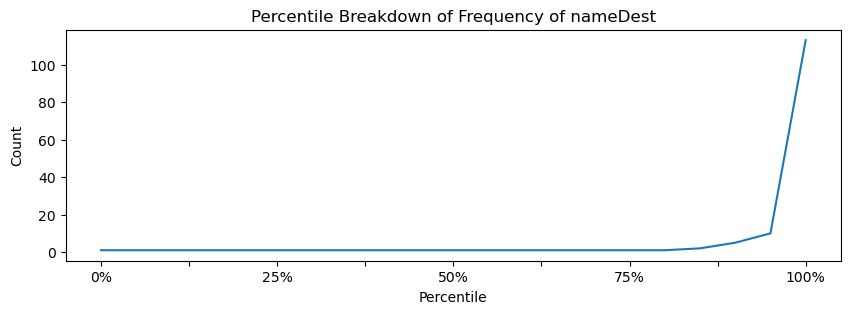

In [384]:
generate_percentile_plot(data=df, col='nameDest')

In [385]:
df['nameDest'].value_counts().describe(np.arange(0, 1.05, .05)).apply(lambda x: f'{x:,.3f}')

count    2,722,362.000
mean             2.337
std              4.549
min              1.000
0%               1.000
5%               1.000
10%              1.000
15%              1.000
20%              1.000
25%              1.000
30%              1.000
35%              1.000
40%              1.000
45%              1.000
50%              1.000
55%              1.000
60%              1.000
65%              1.000
70%              1.000
75%              1.000
80%              1.000
85%              2.000
90%              5.000
95%             10.000
100%           113.000
max            113.000
Name: count, dtype: object

**How many recipients/merchants had more than one transactions?**

`459,658` recipients/merchants had more than one transactions. `95%` of recipients/merchants had 10 or fewer transactions.

In [386]:
count_by_nameDest = df[['nameDest', 'nameDest_count']] \
    .drop_duplicates() \
    .sort_values(by='nameDest_count', ascending=False) \
    .reset_index(drop=True)
count_by_nameDest.head()

,nameDest,nameDest_count
0,C1286084959,113
1,C985934102,109
2,C665576141,105
3,C2083562754,102
4,C248609774,101


In [ ]:
count_by_nameDest['more_than_1_txn'] = np.where(
    count_by_nameDest['nameDest_count'] > 1, 1, 0
)

def format_data(styler):
    styler.set_caption('More Than One Transaction')
    styler.format_index(str.title, axis=1)
    styler.background_gradient(subset=['more_than_1_txn'], vmin=0, vmax=2, cmap='Blues')
    return styler

count_by_nameDest.style.pipe(format_data)

In [388]:
df['nameDest'].value_counts().describe(np.arange(0, 1, .05)).apply(lambda x: f'{x:,.3f}')

count    2,722,362.000
mean             2.337
std              4.549
min              1.000
0%               1.000
5%               1.000
10%              1.000
15%              1.000
20%              1.000
25%              1.000
30%              1.000
35%              1.000
40%              1.000
45%              1.000
50%              1.000
55%              1.000
60%              1.000
65%              1.000
70%              1.000
75%              1.000
80%              1.000
85%              2.000
90%              5.000
95%             10.000
max            113.000
Name: count, dtype: object

**Are there any sender that made multple transactions where only 1 transaction was identified as fraud?**

There are `28` senders who had more than 1 transactions where only 1 of the transactions was identified as fraud.

In [389]:
senders_fraud_list = df.loc[fraud_mask, 'nameOrig'].drop_duplicates().to_list()
print(len(senders_fraud_list))

8213


In [390]:
g = df.loc[
    (df['nameOrig_count'] > 1) & df['nameOrig'].isin(senders_fraud_list), 
    ['nameOrig', 'step', 'type', 'nameDest', 'isFraud']
    ].sort_values(by=['nameOrig', 'step'], ascending=[True, True])

In [391]:
print(len(g['nameOrig'].drop_duplicates()))

28


**Are there any senders who had multiple transactions with the same receiver/merchant where only one of the transactions was identified as fraud?**

No, there aren't any.

In [392]:
d = df.loc[
    (df['nameOrigDest_count'] > 1) & df['nameOrig'].isin(senders_fraud_list), 
    ['nameOrig', 'step', 'type', 'nameDest', 'isFraud']
    ].sort_values(by=['nameOrig', 'step'], ascending=[True, True])

In [393]:
print(len(d['nameOrig'].drop_duplicates()))

0


#### 5.6 isFlaggedFraud

According to the metadata, `isFlaggedFraud` is the business model's aim to control transfers from one account to another by flagging illegal attempts which which are attempts to transfer more than $200.000 in a single transaction.

There are only 16 transactions in the data that have been flagged as fraud by the business model and all of them are type `TRANSFER` and are over 200,000.  However, in analyzing the data, this rule doesn't appear to be accurate as there are 409,094 additional transactions meeting these same criteria that were missed / not flagged.  Essentially, `isFlaggedFraud` does not appear to be a very usefull feature for identifying fraud.

In [27]:
df['isFraud'].value_counts().apply(lambda x: f'{x:,.0f}')

isFraud
0    6,354,407
1        8,213
Name: count, dtype: object

In [24]:
df.loc[fraud_mask, 'isFlaggedFraud'].value_counts().apply(lambda x: f'{x:,.0f}')

isFlaggedFraud
0    8,197
1       16
Name: count, dtype: object

In [23]:
df['isFlaggedFraud'].value_counts().apply(lambda x: f'{x:,.0f}')

isFlaggedFraud
0    6,362,604
1           16
Name: count, dtype: object

In [31]:
flagged = df.loc[
    df['isFlaggedFraud'].eq(1)
    ].sort_values(by=['type', 'step'], ascending=[True, False]).reset_index(drop=True)
flagged

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,741,TRANSFER,5674547.89,C992223106,5674547.89,5674547.89,C1366804249,0.0,0.0,1,1
1,730,TRANSFER,10000000.00,C2140038573,17316255.05,17316255.05,C1395467927,0.0,0.0,1,1
2,730,TRANSFER,7316255.05,C1869569059,17316255.05,17316255.05,C1861208726,0.0,0.0,1,1
3,702,TRANSFER,3171085.59,C1892216157,3171085.59,3171085.59,C1308068787,0.0,0.0,1,1
4,671,TRANSFER,3441041.46,C917414431,3441041.46,3441041.46,C1082139865,0.0,0.0,1,1
5,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1
6,646,TRANSFER,399045.08,C724693370,10399045.08,10399045.08,C1909486199,0.0,0.0,1,1
7,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
8,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
9,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1


In [33]:
flagged['amount'].sort_values().apply(lambda x: f'{x:,.0f}')

8        353,874
6        399,045
13       536,624
14     1,343,002
7      2,542,664
3      3,171,086
4      3,441,041
9      3,576,297
12     4,892,193
15     4,953,893
0      5,674,548
2      7,316,255
11     9,585,040
1     10,000,000
5     10,000,000
10    10,000,000
Name: amount, dtype: object

**Are there other transfers over 200,000 not flagged by the system as fraud?**

Yes, there are 409,110 transfer transactions that are over 200,000 that were not flagged.

In [40]:
print(f"{len(df.loc[(df['amount'] > 200000) & df['type'].eq('TRANSFER')]):,.0f}\n")
print(df.loc[(df['amount'] > 200000) & df['type'].eq('TRANSFER'), 'isFlaggedFraud'].value_counts().apply(lambda x: f'{x:,.0f}'))

409,110

isFlaggedFraud
0    409,094
1         16
Name: count, dtype: object


**Are the transactions flagged as fraud truly fraud?**

Yes, all 16 transactions flagged as fraud were fraudulent ones.

In [29]:
print(len(df.loc[df['isFlaggedFraud'].eq(1) & df['isFraud'].eq(1)]))

16


## 6.0 Feature Engineering

#### 6.1 Step

**Are there certain days of the month where fraud is more likely to occur?**

In [3]:
df['step_days'] = pd.cut(df['step'], bins=30, labels=list(range(1, 31)))

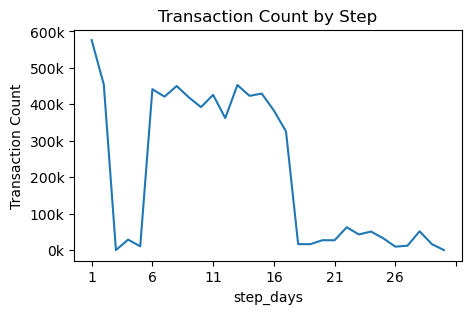

In [10]:
ax = df['step_days'].value_counts().sort_index().plot(figsize=(5, 3))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
ax.set_ylabel('Transaction Count')
ax.set_title('Transaction Count by Step');

In [13]:
step_cont_table = create_contingency_table(df, 'step_days')
step_cont_table[-1]

Chi-Sq Statistic: 522,055.67277
P-value: 0.00000


,step_days,0,1,notFraudExpected,fraudExpected,notFraudChiSq,fraudChiSq,fraudRate
0,1,575564,289,575109.677172,743.322828,0.358904,277.684505,0.000502
1,2,454109,301,453823.438280,586.561720,0.179686,139.022874,0.000662
2,3,0,338,337.563703,0.436297,337.563703,261173.402570,1.000000
3,4,28653,256,28871.683672,37.316328,1.656382,1281.544846,0.008855
4,5,10368,258,10612.283742,13.716258,5.623158,4350.643317,0.024280
5,6,440964,254,440648.466783,569.533217,0.225942,174.811947,0.000576
6,7,420585,282,420323.736270,543.263730,0.162396,125.645672,0.000670
7,8,449685,258,449362.204375,580.795625,0.231878,179.403926,0.000573
8,9,418702,271,418432.181084,540.818916,0.173988,134.614832,0.000647
9,10,391808,284,391585.879629,506.120371,0.125994,97.481671,0.000724


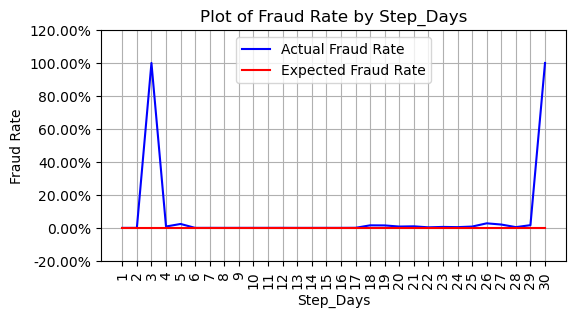

In [16]:
plot_fraud_rate(step_cont_table[-1])

In [17]:
ttest(df, 'step_days')[-1]

T-statistic: 51.46182
P-value: 0.00000


,count,unique,top,freq
isFraud,,,,
0,6354407,28,1,575564
1,8213,30,17,342


#### 6.2 Amount

In [4]:
df['amount_rounded'] = df['amount'].apply(lambda x: round(x, -5))

In [19]:
df['amount_rounded'].value_counts()

amount_rounded
0.0           2805947
100000.0      1347356
200000.0       961834
300000.0       554365
400000.0       275951
               ...   
47000000.0          1
33700000.0          1
32000000.0          1
44500000.0          1
50700000.0          1
Name: count, Length: 480, dtype: int64

In [21]:
df['amount_rounded'].tail()

6362615     300000.0
6362616    6300000.0
6362617    6300000.0
6362618     900000.0
6362619     900000.0
Name: amount_rounded, dtype: float64

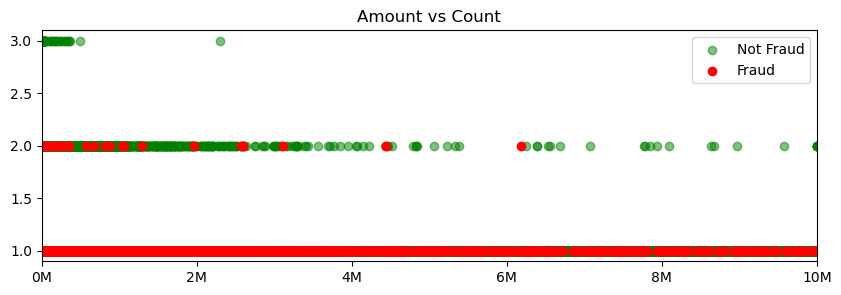

In [103]:
plt.figure(figsize=(10, 3))
plt.title("Amount vs Count")
plt.scatter(df.loc[~fraud_mask, 'amount'], df.loc[~fraud_mask, 'nameOrig_count'], c='g', alpha=.5)
plt.scatter(df.loc[fraud_mask, 'amount'], df.loc[fraud_mask, 'nameOrig_count'], c='r', alpha=.5)
plt.legend(loc='upper right', labels=['Not Fraud','Fraud'])
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_mil))
plt.xlim(0, 10000000);

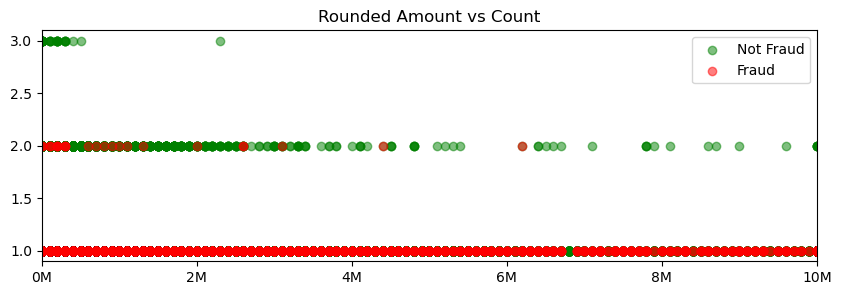

In [28]:
plt.figure(figsize=(10, 3))
plt.title("Rounded Amount vs Count")
plt.scatter(df.loc[~fraud_mask, 'amount_rounded'], df.loc[~fraud_mask, 'nameOrig_count'], c='g', alpha=.5)
plt.scatter(df.loc[fraud_mask, 'amount_rounded'], df.loc[fraud_mask, 'nameOrig_count'], c='r', alpha=.5)
plt.legend(loc='upper right', labels=['Not Fraud','Fraud'])
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_mil))
plt.xlim(0, 10000000);

In [41]:
amt_percentiles = df['amount'].describe(np.arange(0, 1.01, .01)).to_frame()
amt_percentiles[-20:-1].style.format(precision=1, thousands=',', decimal='.')

,amount
82%,"264,365.6"
83%,"273,953.5"
84%,"284,055.7"
85%,"294,919.3"
86%,"306,623.4"
87%,"319,203.4"
88%,"333,045.8"
89%,"348,262.5"
90%,"365,423.3"
91%,"384,851.5"


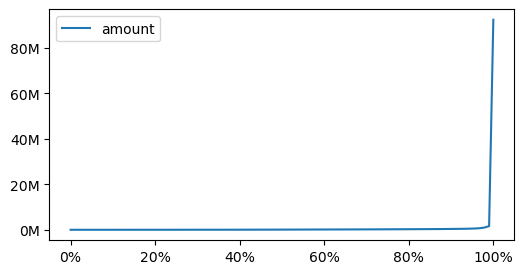

In [93]:
amt_percentiles[4:-1].plot(figsize=(6, 3))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_mil));

In [96]:
fraud_amt_percentiles = df.loc[fraud_mask, 'amount'].describe(np.arange(0, 1.01, .01)).to_frame()
fraud_amt_percentiles[-20:-1].style.format(precision=1, thousands=',', decimal='.')

,amount
82%,"2,277,862.7"
83%,"2,468,740.9"
84%,"2,654,302.5"
85%,"2,873,536.0"
86%,"3,062,506.6"
87%,"3,361,504.6"
88%,"3,642,110.1"
89%,"4,020,778.4"
90%,"4,521,723.5"
91%,"5,031,580.9"


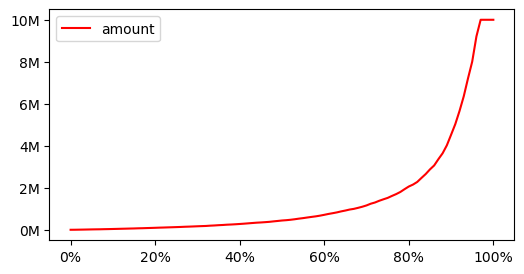

In [94]:
fraud_amt_percentiles[4:-1].plot(figsize=(6, 3), c='red', style='-')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_mil));

In [97]:
nonfraud_amt_percentiles = df.loc[~fraud_mask, 'amount'].describe(np.arange(0, 1.01, .01)).to_frame()
nonfraud_amt_percentiles[-20:-1].style.format(precision=1, thousands=',', decimal='.')

,amount
82%,"263,836.0"
83%,"273,402.6"
84%,"283,463.9"
85%,"294,294.0"
86%,"305,928.1"
87%,"318,443.0"
88%,"332,222.3"
89%,"347,331.9"
90%,"364,373.4"
91%,"383,615.7"


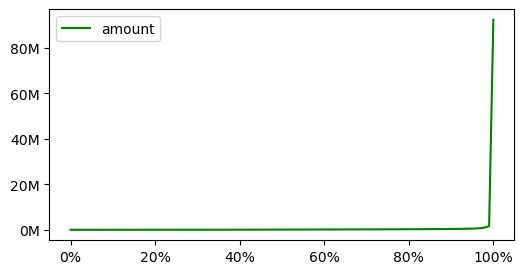

In [98]:
nonfraud_amt_percentiles[4:-1].plot(figsize=(6, 3), c='green', style='-')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_mil));

The median amount for fraud transactions is `$441,423` which at a little over the 90th percentile.  So, let's create a feature to flag amounts over `$400K`.

In [9]:
df['amount_over_400k'] = np.where(df['amount'] > 400000, 1, 0)

## 7.0 Model

#### Handling Imbalanced Data

The dataset is severly imbalanced with fraud transactions accounting for `0.13%` of the data.  The ratio of fraud to non-fraud is `1:773` meaning for every 773 transactions, there is 1 fraud transaction.

Training models on an imbalanced dataset is generally not advised as the machine learning model often prioritizes the majority class (in this case, non-frauds) and can be ineffective in detecting the minor class which is what we want to detect.  Additionally, the overall accuracy score can be misleading as the model could achieve a high-score by predicting that all observations belong to the majority class.

To combat class imbalance, there are a few approaches we can take:
1. Performance Metrics: instead of accuracy, choose performance metrics that can better evaluate how the model separates between the classes (precision, recall/sensitivity, F1-score, ROC curve).  As there's a higher cost associated with FN (500), we want to minimize the false negatives; to obtain this, we'd want to look at the recall/sensitivty.  This metrics measures the proportion of actual positive cases that were correctly identified by a model. A high recall indicates a model that is good at finding fraudulent transactions. 
2. Oversampling: sampling with replacement from the minority class so that the number of fraud equals the higher number of non-fraud. This would result in a dataset almost twice the size of the original.

3. Undersampling: sampling only a fraction from the majority class so that the number of no-fraud equals the lower number of fraud. This would result in a significantly smaller dataset.

4. SMOTE: Synthetic Minority Oversampling Technique - generating synthetic observations from the minority class so that the number of fraud equals the higher number of no-fraud. This would result in a dataset almost twice the size of the original.

In the essense of time, I will be taking approaches 1 and 3 (using the appropriate performance metric to evaluate the models and undersampling the majority class).

In [32]:
df['isFraud'].value_counts().apply(lambda x: f'{x:,.0f}')

isFraud
0    6,354,407
1        8,213
Name: count, dtype: object

In [39]:
print(f'Percentage: {round((8213/6354407) * 100, 2)}%')
print(f'Ratio: 1:{(6354407//8213)}')

Percentage: 0.13%
Ratio: 1:773


#### 7.1 Preprocessing

In [10]:
features_keep = ['step', 'type', 'amount', 'step_days', 'nameOrig_count', 'nameOrigDest_count', 'amount_over_400k', 'isFraud']
temp = df[features_keep]

##### 7.1a Encode Categorical Variables

In [11]:
temp_cat = pd.get_dummies(data=temp, columns=['type'])

In [105]:
temp_cat.head()

,step,amount,step_days,nameOrig_count,nameOrigDest_count,amount_over_400k,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,1,1,1,0,0,False,False,False,True,False
1,1,1864.28,1,1,1,0,0,False,False,False,True,False
2,1,181.00,1,1,1,0,1,False,False,False,False,True
3,1,181.00,1,1,1,0,1,False,True,False,False,False
4,1,11668.14,1,1,1,0,0,False,False,False,True,False


##### 7.1b Undersample Majority Class

In [12]:
# Number of data points in the minority class
fraud_count = len(temp_cat[temp_cat['isFraud'].eq(1)])
fraud_indices = temp_cat[temp_cat['isFraud'].eq(1)].index.values

# Picking the indices of the normal classes
nonfraud_indices = temp_cat[temp_cat['isFraud'].eq(0)].index

# Out of the indices we picked, randomly select "x" number (x - same as total fraud)
random_nonfraud_indices = np.random.choice(nonfraud_indices, fraud_count, replace=False)
random_nonfraud_indices = np.array(random_nonfraud_indices)

# Appending the 2 indices
under_sampled_indices = np.concatenate([fraud_indices, random_nonfraud_indices])
under_sampled_data = temp_cat.iloc[under_sampled_indices, :]

X_undersampled = under_sampled_data.loc[:, under_sampled_data.columns != 'isFraud']
y_undersampled = under_sampled_data.loc[:, under_sampled_data.columns == 'isFraud']

# Showing ratio
print("Percentage of fraud transactions before undersampling: ", round((fraud_count/temp_cat.shape[0]) * 100, 2))
print("Percentage of non-fraud transactions: ", len(under_sampled_data[under_sampled_data.isFraud == 0])/len(under_sampled_data))
print("Percentage of fraud transactions: ", len(under_sampled_data[under_sampled_data.isFraud == 1])/len(under_sampled_data))
print("Total number of transactions in resampled data: ", len(under_sampled_data))

Percentage of fraud transactions before undersampling:  0.13
Percentage of non-fraud transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  16426


In [179]:
X_undersampled.head()

,step,amount,step_days,nameOrig_count,nameOrigDest_count,amount_over_400k,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2,1,181.0,1,1,1,0,False,False,False,False,True
3,1,181.0,1,1,1,0,False,True,False,False,False
251,1,2806.0,1,1,1,0,False,False,False,False,True
252,1,2806.0,1,1,1,0,False,True,False,False,False
680,1,20128.0,1,1,1,0,False,False,False,False,True


In [180]:
y_undersampled.head()

,isFraud
2,1
3,1
251,1
252,1
680,1


##### 7.1c Train/Test/Validation Split

Create a 70/10/15 train/test/validation split.

In [13]:
X = temp_cat.drop('isFraud', axis=1)
y = temp_cat['isFraud']
print(len(X))
print(len(y))

6362620
6362620


In [14]:
print(len(X_undersampled))
print(len(y_undersampled))

16426
16426


In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = \
    create_train_test_val_data(X, y, random_state=1234)

In [18]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(len(X_val), len(y_val))

4771965 4771965
636262 636262
954393 954393


In [19]:
X_train_undersampled, X_test_undersampled, X_val_undersampled, y_train_undersampled, y_test_undersampled, y_val_undersampled = \
    create_train_test_val_data(X_undersampled, y_undersampled, random_state=1234)

In [20]:
print(len(X_train_undersampled), len(y_train_undersampled))
print(len(X_test_undersampled), len(y_test_undersampled))
print(len(X_val_undersampled), len(y_val_undersampled))

12319 12319
1643 1643
2464 2464


##### 7.1d Feature Standardization

In [21]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_val = scaler.transform(X_val)

In [22]:
print(len(scaled_X_train), len(y_train))
print(len(scaled_X_test), len(y_test))
print(len(scaled_X_val), len(y_val))

4771965 4771965
636262 636262
954393 954393


In [23]:
scaler_undersampled = StandardScaler()
scaled_X_train_undersampled = scaler_undersampled.fit_transform(X_train_undersampled)
scaled_X_test_undersampled = scaler_undersampled.transform(X_test_undersampled)
scaled_X_val_undersampled = scaler_undersampled.transform(X_val_undersampled)

In [24]:
print(len(scaled_X_train_undersampled), len(y_train_undersampled))
print(len(scaled_X_test_undersampled), len(y_test_undersampled))
print(len(scaled_X_val_undersampled), len(y_val_undersampled))

12319 12319
1643 1643
2464 2464


#### 7.2 Model Development

Five models were fitted to the data set and performance metrics were calculated to chose the best performing model.

- Baseline Model: Logistic Regression classifier fitted to the unsampled data.
- Logistic Regression classifier on the undersampled data.
- Random Forest classifier on the undersampled data.
- XGBoost classifier on the undersampled data.
- K-Nearest Neighbor classifier on the undersampled data.

#### Logistic Regression

##### Baseline Model (Unsampled dataset - Logistic Regression)

In [40]:
lr = Model(
    scaled_X_train, 
    scaled_X_test, 
    y_train.values, 
    y_test.values, 
    classifier='log_reg'
).fit().predict()

LogisticRegression:
Train Accuracy: 99.87%
Test Accuracy: 99.88%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635482
           1       0.00      0.00      0.00       780

    accuracy                           1.00    636262
   macro avg       0.50      0.50      0.50    636262
weighted avg       1.00      1.00      1.00    636262



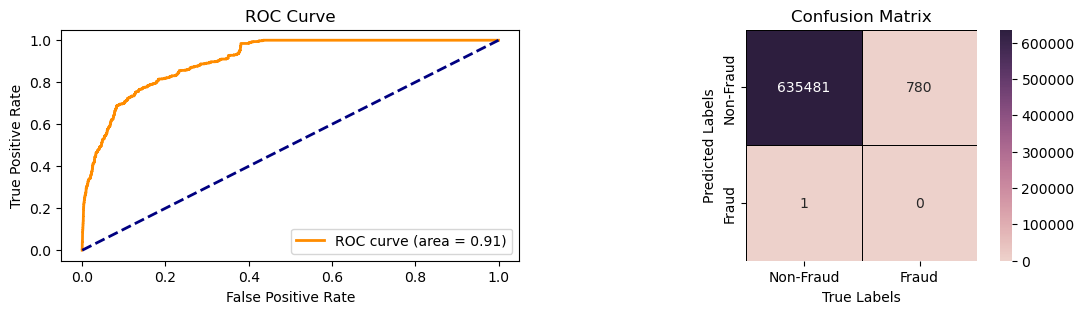

In [41]:
lr.evaluate(cmap=sns.cubehelix_palette(as_cmap=True));

In [42]:
metrics_df = lr.metrics_df
metrics_df.loc[0, 'Classifier'] = 'LogisticRegression - Baseline'
metrics_df

,Classifier,Accuracy,AUC,F1,Precision,Recall,TPR,TNR,FPR,FNR
0,LogisticRegression - Baseline,0.998773,0.499999,0.0,0.0,0.0,0.0,0.999998,0.000002,1.0


##### Logist Regression Classifier on the Undersampled Data

In [43]:
lr_undersampled = Model(
    scaled_X_train_undersampled, 
    scaled_X_test_undersampled, 
    y_train_undersampled.values.ravel(), 
    y_test_undersampled.values.ravel(), 
    classifier='log_reg'
).fit().predict()

LogisticRegression:
Train Accuracy: 85.98%
Test Accuracy: 85.76%
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       817
           1       0.84      0.89      0.86       826

    accuracy                           0.86      1643
   macro avg       0.86      0.86      0.86      1643
weighted avg       0.86      0.86      0.86      1643



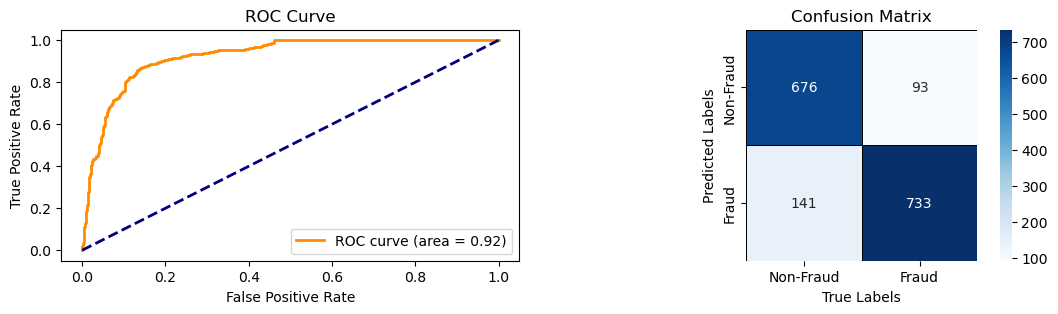

In [44]:
lr_undersampled.evaluate();

In [45]:
lr_undersampled.metrics_df

,Classifier,Accuracy,AUC,F1,Precision,Recall,TPR,TNR,FPR,FNR
0,LogisticRegression,0.857578,0.857413,0.862353,0.838673,0.887409,0.887409,0.827417,0.172583,0.112591


In [46]:
metrics_df = pd.concat([metrics_df, lr_undersampled.metrics_df])
metrics_df

,Classifier,Accuracy,AUC,F1,Precision,Recall,TPR,TNR,FPR,FNR
0,LogisticRegression - Baseline,0.998773,0.499999,0.000000,0.000000,0.000000,0.000000,0.999998,0.000002,1.000000
0,LogisticRegression,0.857578,0.857413,0.862353,0.838673,0.887409,0.887409,0.827417,0.172583,0.112591


#### Random Forest

In [277]:
param_grid = {
              'max_depth': range(1, 13, 2),
              'n_estimators': [64, 100, 128, 200, 250],
              'max_features': range(1, 13, 2),
             }
dt_g = RandomForestClassifier(random_state=1234)
dt_cv = RandomizedSearchCV(dt_g, param_grid, cv=6, scoring='f1_micro', n_jobs=-1)
dt_cv.fit(scaled_X_train_undersampled, y_train_undersampled.values.ravel())

RandomizedSearchCV(cv=6, estimator=RandomForestClassifier(random_state=1234),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 13, 2),
                                        'max_features': range(1, 13, 2),
                                        'n_estimators': [64, 100, 128, 200,
                                                         250]},
                   scoring='f1_micro')

In [278]:
print(f'Best parameters: {dt_cv.best_params_}')
print(f'Accuracy : {round(dt_cv.best_score_, 2)}')

Best parameters: {'n_estimators': 100, 'max_features': 3, 'max_depth': 9}
Accuracy : 0.88


In [47]:
rf_undersampled = Model(
    scaled_X_train_undersampled, 
    scaled_X_test_undersampled, 
    y_train_undersampled.values.ravel(), 
    y_test_undersampled.values.ravel(), 
    classifier='rfc',
    **{'n_estimators': 100, 'max_features': 3, 'max_depth': 9}
).fit().predict()

RandomForestClassifier:
Train Accuracy: 100.0%
Test Accuracy: 89.29%
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       817
           1       0.89      0.90      0.89       826

    accuracy                           0.89      1643
   macro avg       0.89      0.89      0.89      1643
weighted avg       0.89      0.89      0.89      1643



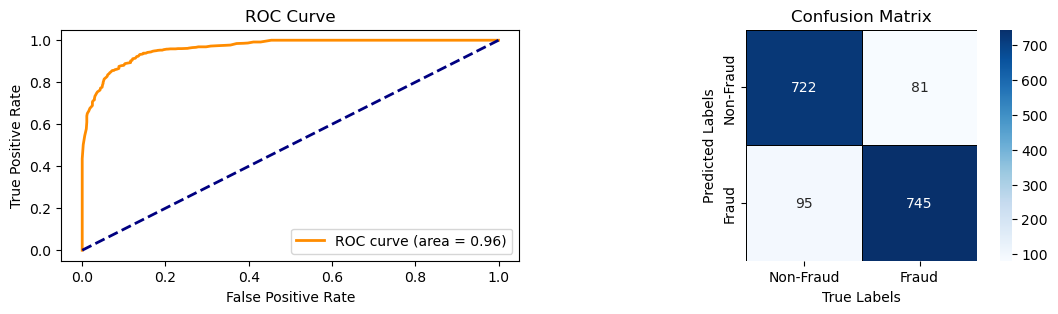

In [48]:
rf_undersampled.evaluate();

In [49]:
metrics_df = pd.concat([metrics_df, rf_undersampled.metrics_df])
metrics_df

,Classifier,Accuracy,AUC,F1,Precision,Recall,TPR,TNR,FPR,FNR
0,LogisticRegression - Baseline,0.998773,0.499999,0.000000,0.000000,0.000000,0.000000,0.999998,0.000002,1.000000
0,LogisticRegression,0.857578,0.857413,0.862353,0.838673,0.887409,0.887409,0.827417,0.172583,0.112591
0,RandomForestClassifier,0.892879,0.892829,0.894358,0.886905,0.901937,0.901937,0.883721,0.116279,0.098063


---

#### XGBoost

In [288]:
# Using Gridsearch to find the best parameters.
param_grid = {'max_depth': range(1, 13, 2),
              # 'n_estimators': [125, 250],
              'n_estimators': [64, 100, 125, 200, 250],
              'min_child_weight': [1, 3, 6]}
dt_g = XGBClassifier(random_state=1234)
dt_cv = GridSearchCV(dt_g, param_grid, cv=6, scoring='f1_micro', n_jobs=-1)
dt_cv.fit(scaled_X_train_undersampled, y_train_undersampled.values.ravel())

GridSearchCV(cv=6,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 13, 2),
                         'min_child_weight': [1, 3, 6],
                         'n_estimators': [64, 100, 125, 200, 250]},
             scoring='f1_micro')

In [289]:
print(f'Best parameters: {dt_cv.best_params_}')
print(f'Accuracy : {round(dt_cv.best_score_, 2)}')

Best parameters: {'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100}
Accuracy : 0.9


In [50]:
xgb_undersampled = Model(
    scaled_X_train_undersampled, 
    scaled_X_test_undersampled, 
    y_train_undersampled.values.ravel(), 
    y_test_undersampled.values.ravel(), 
    classifier='xgboost',
    **{'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100}
).fit().predict()

XGBClassifier:
Train Accuracy: 93.45%
Test Accuracy: 91.91%
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       817
           1       0.92      0.92      0.92       826

    accuracy                           0.92      1643
   macro avg       0.92      0.92      0.92      1643
weighted avg       0.92      0.92      0.92      1643



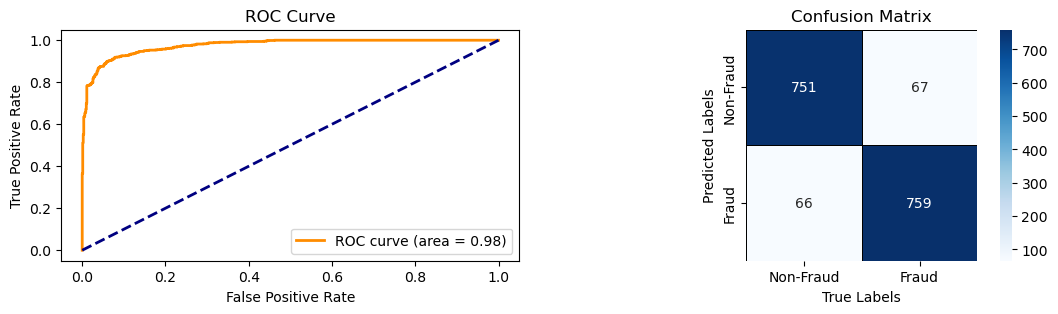

In [51]:
xgb_undersampled.evaluate();

In [52]:
metrics_df = pd.concat([metrics_df, xgb_undersampled.metrics_df])
metrics_df

,Classifier,Accuracy,AUC,F1,Precision,Recall,TPR,TNR,FPR,FNR
0,LogisticRegression - Baseline,0.998773,0.499999,0.000000,0.000000,0.000000,0.000000,0.999998,0.000002,1.000000
0,LogisticRegression,0.857578,0.857413,0.862353,0.838673,0.887409,0.887409,0.827417,0.172583,0.112591
0,RandomForestClassifier,0.892879,0.892829,0.894358,0.886905,0.901937,0.901937,0.883721,0.116279,0.098063
0,XGBClassifier,0.919051,0.919051,0.919443,0.920000,0.918886,0.918886,0.919217,0.080783,0.081114


---

#### K-Nearest Neighbor

In [53]:
knn_undersampled = Model(
    scaled_X_train_undersampled, 
    scaled_X_test_undersampled, 
    y_train_undersampled.values.ravel(), 
    y_test_undersampled.values.ravel(), 
    classifier='knn'
).fit().predict()

KNeighborsClassifier:
Train Accuracy: 91.44%
Test Accuracy: 89.29%
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       817
           1       0.90      0.89      0.89       826

    accuracy                           0.89      1643
   macro avg       0.89      0.89      0.89      1643
weighted avg       0.89      0.89      0.89      1643



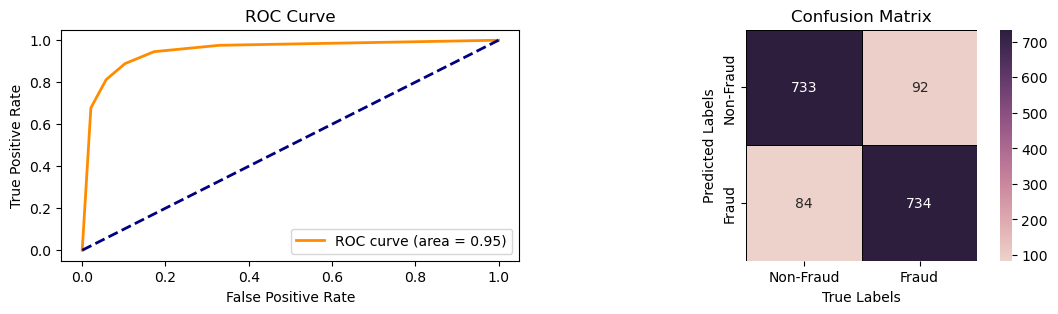

In [54]:
knn_undersampled.evaluate(cmap=sns.cubehelix_palette(as_cmap=True));

In [55]:
metrics_df = pd.concat([metrics_df, knn_undersampled.metrics_df])
metrics_df

,Classifier,Accuracy,AUC,F1,Precision,Recall,TPR,TNR,FPR,FNR
0,LogisticRegression - Baseline,0.998773,0.499999,0.000000,0.000000,0.000000,0.000000,0.999998,0.000002,1.000000
0,LogisticRegression,0.857578,0.857413,0.862353,0.838673,0.887409,0.887409,0.827417,0.172583,0.112591
0,RandomForestClassifier,0.892879,0.892829,0.894358,0.886905,0.901937,0.901937,0.883721,0.116279,0.098063
0,XGBClassifier,0.919051,0.919051,0.919443,0.920000,0.918886,0.918886,0.919217,0.080783,0.081114
0,KNeighborsClassifier,0.892879,0.892902,0.892944,0.897311,0.888620,0.888620,0.897185,0.102815,0.111380


In [307]:
svm_undersampled = Model(
    scaled_X_train_undersampled, 
    scaled_X_test_undersampled, 
    y_train_undersampled.values.ravel(), 
    y_test_undersampled.values.ravel(), 
    classifier='svm'
).fit().predict()

In [308]:
svm_undersampled.evaluate();

SVC:
Train Accuracy: 86.42%
Test Accuracy: 87.16%
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       817
           1       0.88      0.86      0.87       826

    accuracy                           0.87      1643
   macro avg       0.87      0.87      0.87      1643
weighted avg       0.87      0.87      0.87      1643



AttributeError: 'SVC' object has no attribute '_predict_proba_lr'

## 8.0 Model Evaluation

A logistic regression model was fitted to both the normal data and the undersampled data and performance metrics were calculated.  The model fitted to the normal or unsampled data is the baseline model.

As predicted, training and testing accuracy percentage was close to 99% for the normal data with highly class imbalance; however, recall, f1-score, and TPR were 0, meaning this model was completely unable to detect any instances of fraud.

The logistic regression model fitted to the undersampled dataset performed significantly better with a recall and TPR of ~90%.  The Area under the Curve score also improved from 50% which is little better than random chance to 87%.

The best performing model is XGBoost with a TPR of 92% which means it was able to correctly identified 92% of the actual fraud cases.

In [56]:
metrics_df.reset_index(drop=True, inplace=True)

In [57]:
metrics_df

,Classifier,Accuracy,AUC,F1,Precision,Recall,TPR,TNR,FPR,FNR
0,LogisticRegression - Baseline,0.998773,0.499999,0.000000,0.000000,0.000000,0.000000,0.999998,0.000002,1.000000
1,LogisticRegression,0.857578,0.857413,0.862353,0.838673,0.887409,0.887409,0.827417,0.172583,0.112591
2,RandomForestClassifier,0.892879,0.892829,0.894358,0.886905,0.901937,0.901937,0.883721,0.116279,0.098063
3,XGBClassifier,0.919051,0.919051,0.919443,0.920000,0.918886,0.918886,0.919217,0.080783,0.081114
4,KNeighborsClassifier,0.892879,0.892902,0.892944,0.897311,0.888620,0.888620,0.897185,0.102815,0.111380


In [58]:
validation_score = xgb_undersampled.model.score(scaled_X_val_undersampled, y_val_undersampled)
print(f"Validation Score: {validation_score}")

Validation Score: 0.8896103896103896


In [59]:
y_pred_val = xgb_undersampled.model.predict(scaled_X_val_undersampled)
accuracy = accuracy_score(y_val_undersampled, y_pred_val)
print(f"Validation Accuracy: {accuracy}")
print(classification_report(y_val_undersampled, y_pred_val))

Validation Accuracy: 0.8896103896103896
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1254
           1       0.88      0.89      0.89      1210

    accuracy                           0.89      2464
   macro avg       0.89      0.89      0.89      2464
weighted avg       0.89      0.89      0.89      2464



In [60]:
y_pred_prob = xgb_undersampled.model.predict_proba(scaled_X_val_undersampled)

In [61]:
scores_df = pd.concat([
    X_val_undersampled, 
    y_val_undersampled, 
    pd.DataFrame(y_pred_val, index=y_val_undersampled.index, columns=['score']),
    pd.DataFrame(y_pred_prob, index=y_val_undersampled.index, columns=['noFraudProb', 'fraudProb']),
], axis=1).reset_index(drop=False).rename(columns={'index': 'transaction_id'})[[
    'transaction_id', 'isFraud', 'score', 'fraudProb'
]]

In [62]:
scores_df.head()

,transaction_id,isFraud,score,fraudProb
0,4424191,0,0,0.475198
1,178903,0,0,0.031478
2,3232568,0,0,0.000560
3,1070153,1,1,0.984823
4,2823002,0,0,0.000387


In [376]:
scores_df.to_csv('data/scores.csv')

### Feature Importances

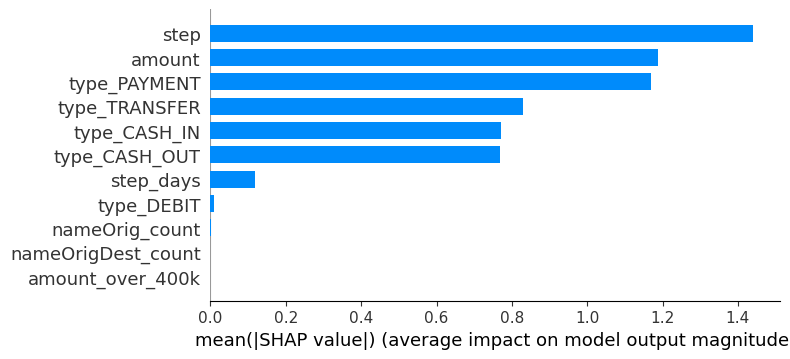

In [66]:
# Explain feature importance using SHAP
explainer = shap.Explainer(xgb_undersampled.model)
shap_values = explainer.shap_values(scaled_X_test_undersampled)

# Create a summary plot
shap.summary_plot(shap_values, X_test_undersampled, plot_type='bar', plot_size= 0.2)
plt.show();

## 9.0 Further Explorations

**Additional Features to Explore**:
- transaction patterns: transfer then cash-out
- if different hours of the day are more likely to have fraud occur
- zero-out balance due to transaction